# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [ ]:
env = UnityEnvironment(file_name="Banana.app")

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [ ]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

# Agent and Network

In [5]:
import torch
from torch import nn
import torch.nn.functional as F
from collections import deque
import random
import torch.optim as optim

class Network(nn.Module):

    def __init__(self, state_size, action_size, layers, use_dueling_dqn=False):
        super().__init__()

        self.layers = nn.ModuleList([nn.Linear(state_size, layers[0])])
        self.layers.extend([nn.Linear(i, o) for i, o in zip(layers[:-1], layers[1:])])
        self.use_dueling_dqn = use_dueling_dqn
        self.state_size = state_size
        self.action_size = action_size

        if use_dueling_dqn:
            self.advantage = nn.Sequential(
                nn.Linear(layers[-1], layers[-1]),
                nn.ELU(),
                nn.Linear(layers[-1], action_size)
            )
            self.value = nn.Sequential(
                nn.Linear(layers[-1], layers[-1]),
                nn.ELU(),
                nn.Linear(layers[-1], 1)
            )

        self.output = nn.Linear(layers[-1], action_size)
    
    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = F.elu(layer(x))

        if self.use_dueling_dqn:
            advantage = self.advantage(x)
            value = self.value(x)
            return value + advantage - advantage.mean()

        return self.output(x)
    
    def save(self, filepath='checkpoint.pth'):
        checkpoint = {
            'state_size': self.state_size,
            'action_size': self.action_size,
            'layers': [each.out_features for each in self.layers],
            'use_dueling_dqn': self.use_dueling_dqn,
            'state_dict': self.state_dict()
        }
        torch.save(checkpoint, filepath)

    # static method to load saved network
    def load(filepath='checkpoint.pth'):
        checkpoint = torch.load(filepath)
        network = Network(
            checkpoint['state_size'],
            checkpoint['action_size'],
            layers=checkpoint['layers'],
            use_dueling_dqn=checkpoint['use_dueling_dqn']
        )
        network.load_state_dict(checkpoint['state_dict'])
        return network

class ReplayBuffer():

    def __init__(self, buffer_size):
        self.memory = deque(maxlen=buffer_size)
    
    def add(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        experiences = random.sample(self.memory, k=batch_size)
        experiences = [np.array(a) for a in zip(*experiences)]
        return experiences
    
    def __len__(self):
        return len(self.memory)
    
class Agent():

    def __init__(
        self, 
        state_size,
        action_size, 
        use_double_dqn=False,
        use_dueling_dqn=False,
        hidden_layers=[64, 64], # neural network hidden layers
        update_every=4, # how often to update the network
        batch_size=64, # minibatch size
        tau=1e-3, # for soft update of target parameters
        lr=5e-4, # learning rate 
        gamma=0.99, # discount factor
        buffer_size=int(1e5), # replay buffer size
        epsilon=1.0, # exploration probability
        epsilon_decay=0.97,
        epsilon_min=0.02
    ):

        self.buffer_size = buffer_size 
        self.gamma = gamma 
        self.tau = tau
        self.lr = lr
        self.update_every = update_every 
        self.batch_size = batch_size 
        
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        self.use_double_dqn = use_double_dqn
        self.use_dueling_dqn = use_dueling_dqn

        self.hidden_layers = hidden_layers
        self.action_size = action_size
        self.state_size = state_size
        self.qnetwork_local = Network(state_size, action_size, hidden_layers, use_dueling_dqn)
        self.qnetwork_target = Network(state_size, action_size, hidden_layers, use_dueling_dqn)
        self.memory = ReplayBuffer(self.buffer_size)
        self.t_step = 0
        
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=self.lr)
        
    def load(self, filepath):
        self.qnetwork_local = Network.load(filepath)
        self.qnetwork_target = Network.load(filepath)
        
    def save(self, filepath):
        self.qnetwork_local.save(filepath)

    def act(self, state):
        probs = self.get_probs(state)
        action = np.random.choice(self.action_size, p=probs)
        return action
    
    def get_probs(self, state):
        probs = np.full(action_size, self.epsilon / self.action_size)
        best_action = self.get_best_action(state)
        probs[best_action] += 1 - self.epsilon
        return probs
    
    def get_best_action(self, state):
        action = None

        self.qnetwork_local.eval()
        with torch.no_grad():
            state = torch.tensor(state).float().unsqueeze(0)
            best = self.qnetwork_local.forward(state).max(1)
            action = best[1].item()
        self.qnetwork_local.train()

        return action
    
    def step(self, state, action, reward, next_state, done):
        pass
        self.t_step += 1
        self.memory.add(state, action, reward, next_state, done)
        
        self.t_step %= self.update_every
        if self.t_step == 0 and len(self.memory) >= self.batch_size:
            self.learn()
            
        if done:
            self.epsilon = max(self.epsilon_min, self.epsilon_decay*self.epsilon)
    
    def learn(self):
        experiences = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = experiences
        
        states = torch.FloatTensor(states)
        next_states = torch.FloatTensor(next_states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        dones = torch.FloatTensor(dones.astype(np.uint8))
        
        q_values = self.qnetwork_local(states)
        q_values_next = self.qnetwork_local(next_states)
        q_values_next_ = self.qnetwork_target(next_states)
        
        Q_targets_next = None
        if self.use_double_dqn:
            best_next_actions = q_values_next.detach().max(1)[1].unsqueeze(1)
            Q_targets_next = q_values_next_.gather(1, best_next_actions).squeeze()
        else:
            Q_targets_next = q_values_next_.detach().max(1)[0]
        
        Q_targets = rewards + self.gamma * Q_targets_next * (1 - dones)
        Q_expected = q_values.gather(1, actions.unsqueeze(1)).squeeze()

        self.optimizer.zero_grad()
        loss = F.mse_loss(Q_expected, Q_targets)
        loss.backward()
        self.optimizer.step()
        
        self.soft_update()
        
    def soft_update(self):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        """
        for target, local in zip(self.qnetwork_target.parameters(), self.qnetwork_local.parameters()):
            target.data.copy_(self.tau * local.data + (1 - self.tau) * target.data)

# Training the Agent

Next, start the environment with graphics turned off so that the agent can train without the overehead of rendering the display.

In [4]:
env = UnityEnvironment(file_name="Banana.app", no_graphics=True)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
state_size = brain.vector_observation_space_size
action_size = brain.vector_action_space_size

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [5]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def train(agent, label='agent', episodes=1000, plot_every=10, print_every=100, stop_when_solved=True):
    
    scores = []
    tmp_scores = deque(maxlen=100)
    solved = False

    for episode in range(1, episodes+1):

        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        average = 0
        best = 0

        while True:

            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]

            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward

            if done:
                tmp_scores.append(score)
                average = np.mean(tmp_scores)
                if average > best:
                    best = average
                    agent.save("checkpoints/{}.pth".format(label))

                if episode % plot_every == 0:
                    scores.append((episode, average))
                if episode % print_every == 0:
                    print("Episode: {}\tAverage Score: {:.2f}".format(episode, average))
                break

        # solved if average over last 100 episodes is at least 13
        if !solved and average >= 13.0:
            solved = True
            print("Environment solved in {} episodes!\tAverage Score: {:.2f}".format(episode, average))
            if stop_when_solved:
                break

    return scores

def plot_scores(scores):
    for label in scores:
        x, y = zip(*scores[label])
        plt.plot(x, y, label=label)
    plt.legend()
    plt.xlabel('Episode')
    plt.ylabel('Average Score')
    plt.show()

# Exploring Architecture and Parameters

Next I explore different network architectures and hyperparameters to find an agent that learns the environment efficiently.  Because of the time required to test each agent, I do not try all the combinations of each parameter, but instead evaluate each parameter while leaving the rest set to the the defaults.  I also quit as soon as the environment is solved, so it is possible that some of these parameters work well early on but do not do as well if allowed to train longer.

In [4]:
agents = {
    "DQN": Agent(state_size, action_size),
    "Dueling DQN": Agent(state_size, action_size, use_dueling_dqn=False),
    "DDQN": Agent(state_size, action_size, use_double_dqn=True),
    "Dueling DDQN": Agent(state_size, action_size, use_dueling_dqn=True, use_double_dqn=True),
    "Layers=128,64": Agent(state_size, action_size, hidden_layers=[128,64]),
    "Layers=64,32": Agent(state_size, action_size, hidden_layers=[64,32]),
    "Layers=32,32": Agent(state_size, action_size, hidden_layers=[32,32]),
    "Gamma=1.0": Agent(state_size, action_size, gamma=1.0),
    "Gamma=.95": Agent(state_size, action_size, gamma=0.95),
    "LR=1e-3": Agent(state_size, action_size, lr=1e-3),
    "LR=1e-4": Agent(state_size, action_size, lr=1e-4),
    "Tau=1e-1": Agent(state_size, action_size, tau=1e-1),
    "Tau=1e-2": Agent(state_size, action_size, tau=1e-2),
    "Tau=1e-4": Agent(state_size, action_size, tau=1e-4),
    "EpsilonMin=.01": Agent(state_size, action_size, epsilon_min=0.01),
    "EpsilonDecay=.98": Agent(state_size, action_size, epsilon_decay=0.98),
    "EpsilonDecay=.99": Agent(state_size, action_size, epsilon_decay=0.99),
    "Buffer=1e4": Agent(state_size, action_size, buffer_size=int(1e4)),
    "Buffer=1e6": Agent(state_size, action_size, buffer_size=int(1e6)),
}
scores = {}
for agent in agents:
    print("Training Agent: {}".format(agent))
    scores[agent] = train(agents[agent], label=agent)
plot_scores(scores)

NameError: name 'Agent' is not defined

# Trained Agent

After finding an architecture and hyperparameters that learn the environment efficiently, I train over more episodes to get an agent that performs even better than the initial solution.  Checkpoints save each time the running average over 100 episodes is increased.

In [9]:
print('Training Agent')
agent = Agent(state_size, action_size, use_dueling_dqn=True, use_double_dqn=True)
scores = train(agent, label='final', episodes=2000, stop_when_solved=False)
print('Done')

Training Agent
Episode: 100	Average Score: 3.92
Episode: 200	Average Score: 9.11
Episode: 300	Average Score: 12.13
Environment solved in 340 episodes!	Average Score: 13.10
Environment solved in 341 episodes!	Average Score: 13.11
Environment solved in 342 episodes!	Average Score: 13.12
Environment solved in 343 episodes!	Average Score: 13.11
Environment solved in 344 episodes!	Average Score: 13.14
Environment solved in 345 episodes!	Average Score: 13.07
Environment solved in 352 episodes!	Average Score: 13.11
Environment solved in 353 episodes!	Average Score: 13.22
Environment solved in 354 episodes!	Average Score: 13.21
Environment solved in 355 episodes!	Average Score: 13.22
Environment solved in 356 episodes!	Average Score: 13.24
Environment solved in 357 episodes!	Average Score: 13.35
Environment solved in 358 episodes!	Average Score: 13.35
Environment solved in 359 episodes!	Average Score: 13.33
Environment solved in 360 episodes!	Average Score: 13.31
Environment solved in 361 epis

Environment solved in 488 episodes!	Average Score: 15.63
Environment solved in 489 episodes!	Average Score: 15.65
Environment solved in 490 episodes!	Average Score: 15.67
Environment solved in 491 episodes!	Average Score: 15.78
Environment solved in 492 episodes!	Average Score: 15.78
Environment solved in 493 episodes!	Average Score: 15.79
Environment solved in 494 episodes!	Average Score: 15.71
Environment solved in 495 episodes!	Average Score: 15.68
Environment solved in 496 episodes!	Average Score: 15.72
Environment solved in 497 episodes!	Average Score: 15.71
Environment solved in 498 episodes!	Average Score: 15.69
Environment solved in 499 episodes!	Average Score: 15.70
Episode: 500	Average Score: 15.65
Environment solved in 500 episodes!	Average Score: 15.65
Environment solved in 501 episodes!	Average Score: 15.79
Environment solved in 502 episodes!	Average Score: 15.83
Environment solved in 503 episodes!	Average Score: 15.77
Environment solved in 504 episodes!	Average Score: 15.

Environment solved in 631 episodes!	Average Score: 15.75
Environment solved in 632 episodes!	Average Score: 15.80
Environment solved in 633 episodes!	Average Score: 15.77
Environment solved in 634 episodes!	Average Score: 15.82
Environment solved in 635 episodes!	Average Score: 15.77
Environment solved in 636 episodes!	Average Score: 15.79
Environment solved in 637 episodes!	Average Score: 15.78
Environment solved in 638 episodes!	Average Score: 15.81
Environment solved in 639 episodes!	Average Score: 15.95
Environment solved in 640 episodes!	Average Score: 15.98
Environment solved in 641 episodes!	Average Score: 16.01
Environment solved in 642 episodes!	Average Score: 15.96
Environment solved in 643 episodes!	Average Score: 15.92
Environment solved in 644 episodes!	Average Score: 15.88
Environment solved in 645 episodes!	Average Score: 15.86
Environment solved in 646 episodes!	Average Score: 15.92
Environment solved in 647 episodes!	Average Score: 15.85
Environment solved in 648 episo

Environment solved in 775 episodes!	Average Score: 15.84
Environment solved in 776 episodes!	Average Score: 15.85
Environment solved in 777 episodes!	Average Score: 15.81
Environment solved in 778 episodes!	Average Score: 15.81
Environment solved in 779 episodes!	Average Score: 15.86
Environment solved in 780 episodes!	Average Score: 15.78
Environment solved in 781 episodes!	Average Score: 15.70
Environment solved in 782 episodes!	Average Score: 15.67
Environment solved in 783 episodes!	Average Score: 15.71
Environment solved in 784 episodes!	Average Score: 15.74
Environment solved in 785 episodes!	Average Score: 15.74
Environment solved in 786 episodes!	Average Score: 15.64
Environment solved in 787 episodes!	Average Score: 15.67
Environment solved in 788 episodes!	Average Score: 15.62
Environment solved in 789 episodes!	Average Score: 15.61
Environment solved in 790 episodes!	Average Score: 15.52
Environment solved in 791 episodes!	Average Score: 15.48
Environment solved in 792 episo

Environment solved in 918 episodes!	Average Score: 16.15
Environment solved in 919 episodes!	Average Score: 16.19
Environment solved in 920 episodes!	Average Score: 16.19
Environment solved in 921 episodes!	Average Score: 16.17
Environment solved in 922 episodes!	Average Score: 16.30
Environment solved in 923 episodes!	Average Score: 16.28
Environment solved in 924 episodes!	Average Score: 16.22
Environment solved in 925 episodes!	Average Score: 16.34
Environment solved in 926 episodes!	Average Score: 16.30
Environment solved in 927 episodes!	Average Score: 16.33
Environment solved in 928 episodes!	Average Score: 16.32
Environment solved in 929 episodes!	Average Score: 16.30
Environment solved in 930 episodes!	Average Score: 16.39
Environment solved in 931 episodes!	Average Score: 16.48
Environment solved in 932 episodes!	Average Score: 16.43
Environment solved in 933 episodes!	Average Score: 16.46
Environment solved in 934 episodes!	Average Score: 16.41
Environment solved in 935 episo

Environment solved in 1061 episodes!	Average Score: 16.78
Environment solved in 1062 episodes!	Average Score: 16.77
Environment solved in 1063 episodes!	Average Score: 16.77
Environment solved in 1064 episodes!	Average Score: 16.78
Environment solved in 1065 episodes!	Average Score: 16.72
Environment solved in 1066 episodes!	Average Score: 16.80
Environment solved in 1067 episodes!	Average Score: 16.87
Environment solved in 1068 episodes!	Average Score: 16.86
Environment solved in 1069 episodes!	Average Score: 16.84
Environment solved in 1070 episodes!	Average Score: 16.81
Environment solved in 1071 episodes!	Average Score: 16.81
Environment solved in 1072 episodes!	Average Score: 16.90
Environment solved in 1073 episodes!	Average Score: 16.81
Environment solved in 1074 episodes!	Average Score: 16.88
Environment solved in 1075 episodes!	Average Score: 16.87
Environment solved in 1076 episodes!	Average Score: 16.82
Environment solved in 1077 episodes!	Average Score: 16.86
Environment so

Environment solved in 1202 episodes!	Average Score: 17.03
Environment solved in 1203 episodes!	Average Score: 16.96
Environment solved in 1204 episodes!	Average Score: 16.95
Environment solved in 1205 episodes!	Average Score: 16.96
Environment solved in 1206 episodes!	Average Score: 16.88
Environment solved in 1207 episodes!	Average Score: 16.84
Environment solved in 1208 episodes!	Average Score: 16.85
Environment solved in 1209 episodes!	Average Score: 16.86
Environment solved in 1210 episodes!	Average Score: 16.78
Environment solved in 1211 episodes!	Average Score: 16.79
Environment solved in 1212 episodes!	Average Score: 16.77
Environment solved in 1213 episodes!	Average Score: 16.76
Environment solved in 1214 episodes!	Average Score: 16.77
Environment solved in 1215 episodes!	Average Score: 16.74
Environment solved in 1216 episodes!	Average Score: 16.80
Environment solved in 1217 episodes!	Average Score: 16.73
Environment solved in 1218 episodes!	Average Score: 16.66
Environment so

Environment solved in 1343 episodes!	Average Score: 15.89
Environment solved in 1344 episodes!	Average Score: 15.84
Environment solved in 1345 episodes!	Average Score: 15.84
Environment solved in 1346 episodes!	Average Score: 15.87
Environment solved in 1347 episodes!	Average Score: 15.87
Environment solved in 1348 episodes!	Average Score: 15.83
Environment solved in 1349 episodes!	Average Score: 15.70
Environment solved in 1350 episodes!	Average Score: 15.69
Environment solved in 1351 episodes!	Average Score: 15.68
Environment solved in 1352 episodes!	Average Score: 15.78
Environment solved in 1353 episodes!	Average Score: 15.84
Environment solved in 1354 episodes!	Average Score: 15.90
Environment solved in 1355 episodes!	Average Score: 15.93
Environment solved in 1356 episodes!	Average Score: 15.85
Environment solved in 1357 episodes!	Average Score: 15.83
Environment solved in 1358 episodes!	Average Score: 15.84
Environment solved in 1359 episodes!	Average Score: 15.80
Environment so

Environment solved in 1484 episodes!	Average Score: 15.59
Environment solved in 1485 episodes!	Average Score: 15.56
Environment solved in 1486 episodes!	Average Score: 15.59
Environment solved in 1487 episodes!	Average Score: 15.57
Environment solved in 1488 episodes!	Average Score: 15.56
Environment solved in 1489 episodes!	Average Score: 15.54
Environment solved in 1490 episodes!	Average Score: 15.56
Environment solved in 1491 episodes!	Average Score: 15.52
Environment solved in 1492 episodes!	Average Score: 15.56
Environment solved in 1493 episodes!	Average Score: 15.72
Environment solved in 1494 episodes!	Average Score: 15.69
Environment solved in 1495 episodes!	Average Score: 15.66
Environment solved in 1496 episodes!	Average Score: 15.58
Environment solved in 1497 episodes!	Average Score: 15.60
Environment solved in 1498 episodes!	Average Score: 15.45
Environment solved in 1499 episodes!	Average Score: 15.41
Episode: 1500	Average Score: 15.48
Environment solved in 1500 episodes!	

Environment solved in 1625 episodes!	Average Score: 16.31
Environment solved in 1626 episodes!	Average Score: 16.25
Environment solved in 1627 episodes!	Average Score: 16.25
Environment solved in 1628 episodes!	Average Score: 16.28
Environment solved in 1629 episodes!	Average Score: 16.30
Environment solved in 1630 episodes!	Average Score: 16.25
Environment solved in 1631 episodes!	Average Score: 16.22
Environment solved in 1632 episodes!	Average Score: 16.15
Environment solved in 1633 episodes!	Average Score: 16.27
Environment solved in 1634 episodes!	Average Score: 16.29
Environment solved in 1635 episodes!	Average Score: 16.33
Environment solved in 1636 episodes!	Average Score: 16.30
Environment solved in 1637 episodes!	Average Score: 16.28
Environment solved in 1638 episodes!	Average Score: 16.29
Environment solved in 1639 episodes!	Average Score: 16.29
Environment solved in 1640 episodes!	Average Score: 16.26
Environment solved in 1641 episodes!	Average Score: 16.33
Environment so

Environment solved in 1766 episodes!	Average Score: 15.87
Environment solved in 1767 episodes!	Average Score: 15.88
Environment solved in 1768 episodes!	Average Score: 15.93
Environment solved in 1769 episodes!	Average Score: 16.02
Environment solved in 1770 episodes!	Average Score: 16.03
Environment solved in 1771 episodes!	Average Score: 16.00
Environment solved in 1772 episodes!	Average Score: 15.86
Environment solved in 1773 episodes!	Average Score: 15.91
Environment solved in 1774 episodes!	Average Score: 15.82
Environment solved in 1775 episodes!	Average Score: 15.84
Environment solved in 1776 episodes!	Average Score: 15.85
Environment solved in 1777 episodes!	Average Score: 15.81
Environment solved in 1778 episodes!	Average Score: 15.78
Environment solved in 1779 episodes!	Average Score: 15.77
Environment solved in 1780 episodes!	Average Score: 15.73
Environment solved in 1781 episodes!	Average Score: 15.70
Environment solved in 1782 episodes!	Average Score: 15.74
Environment so

Environment solved in 1907 episodes!	Average Score: 15.16
Environment solved in 1908 episodes!	Average Score: 15.12
Environment solved in 1909 episodes!	Average Score: 15.16
Environment solved in 1910 episodes!	Average Score: 15.10
Environment solved in 1911 episodes!	Average Score: 15.07
Environment solved in 1912 episodes!	Average Score: 15.00
Environment solved in 1913 episodes!	Average Score: 15.06
Environment solved in 1914 episodes!	Average Score: 15.03
Environment solved in 1915 episodes!	Average Score: 15.11
Environment solved in 1916 episodes!	Average Score: 15.11
Environment solved in 1917 episodes!	Average Score: 15.11
Environment solved in 1918 episodes!	Average Score: 15.18
Environment solved in 1919 episodes!	Average Score: 15.23
Environment solved in 1920 episodes!	Average Score: 15.26
Environment solved in 1921 episodes!	Average Score: 15.28
Environment solved in 1922 episodes!	Average Score: 15.34
Environment solved in 1923 episodes!	Average Score: 15.33
Environment so

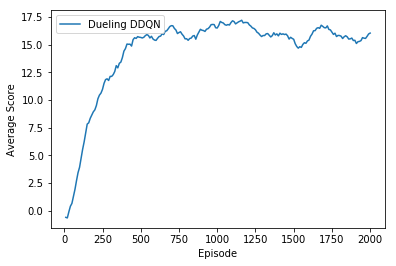

In [14]:
plot_scores({'Dueling DDQN': scores})

In [2]:
env = UnityEnvironment(file_name="Banana.app")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
state_size = brain.vector_observation_space_size
action_size = brain.vector_action_space_size

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [8]:
agent = Agent(state_size, action_size, epsilon=0)
agent.load("checkpoints/final.pth")
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
score = 0
while True:
    action = agent.act(state)
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    state = next_state
    score += reward
    if done:
        break
print("Score: {}".format(score))

Score: 18.0
